In [1]:
import pandas as pd

In [2]:
sapro = pd.read_excel('sapro_full.xlsx')

In [7]:
sapro.head()

,Administrative Discharge Type,Adverse Administrative Action Type,Alcohol Use,Case Disposition,Case Synopsis,Case Synopsis Note,Confinement (Court Only),Correctional Custody (NJP Only),Court Case or Article 15 Outcome,Court- Martial Discharge,...,Subject: Moral Waiver Accession,Subject: Moral Waiver Accession?,Subject: Moral Waiver Acession?,Subject: Prior Investigation for Sex Assault?,Victim Affiliation,Victim Gender,Victim Pay Grade,Victim Service,Year,Outcome
0,General,NaN,NaN,Sexual Assault Offense: Administrative Discharge,NaN,NaN,NaN,NaN,Art 15 Punishment Imposed,NaN,...,NaN,NaN,NaN,NaN,NaN,Multiple Victims - Male & Female,Multiple Victims,NaN,2013,no court-martial
1,General,NaN,NaN,Sexual Assault Offense: Administrative Discharge,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Male,E-3,Army,2013,no court-martial
2,General,NaN,Involved but not specified.,Sexual Assault Offense: Administrative Discharge,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Female,US Civilian,NaN,2013,no court-martial
3,Pending,NaN,NaN,Sexual Assault Offense: Administrative Discharge,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Female,E-4,Army,2013,no court-martial
4,Uncharacterized,NaN,NaN,Non-Sexual Assault Offense: Administrative Dis...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Male,E-2,Army,2013,no court-martial


In [6]:
summaries = pd.read_csv('summary_full.csv', index_col=0)

In [5]:
summaries.shape

(5306, 23)

# Summaries: Do drug-related court martials face higher penalities than sexual assault?

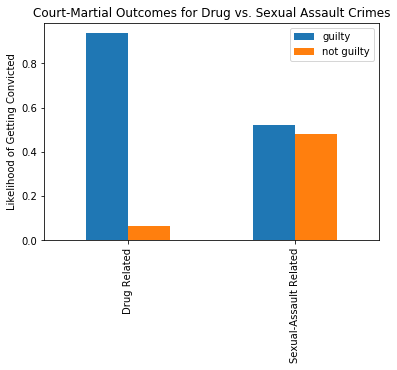

In [915]:
pd.concat([
    summaries[summaries['Offense'].fillna('').apply(lambda x: 'drug' in x.lower())]['Conclusion'].value_counts().to_frame('Drug Related'),
    summaries[summaries['Offense'].fillna('').apply(lambda x: 'sex' in x.lower())]['Conclusion'].value_counts().to_frame('Sexual-Assault Related')
], axis=1).pipe(lambda df: df / df.sum()).T.plot.bar()
plt.title('Court-Martial Outcomes for Drug vs. Sexual Assault Crimes')
plt.ylabel('Likelihood of Getting Convicted');

In [29]:
summaries[summaries['Offense'].fillna('').apply(lambda x: 'drug' in x.lower())]['Sentence'].head().values

array([' by officer members to hard labor without confinement for  two months,  reduction to Airman First Class (E-3),  and forfeiture of $500 pay per month for  four months',
       ' to a reprimand,  reduction to Senior Airman (E-4),  and  confinement for 45 days',
       ' to a bad conduct discharge,  confinement for 3 months,  and  reduction to Airman Basic (E-1)',
       ' to reduction to Airman Basic  (E-1),  confinement for 12 months,  and forfeiture of $996 pay per month for 12 months',
       ' to reduction to Airman Basic  (E-1),  a reprimand,  confinement for six months,  and total forfeitures'],
      dtype=object)

In [967]:
summaries['split-punishment'] = (summaries['Sentence']
 .fillna('')
 .apply(lambda x: x.replace('the accused', '').strip())
 .apply(lambda x: map(lambda x: (' '.join(x.replace('be','')
                                 .replace(',','')
                                 .replace('to','')
                                 .strip().split())),
                      re.split('\,\sto|\sand\s|\s\,', x))
       )
)

In [968]:
summaries[summaries['Offense'].fillna('').apply(lambda x: 'drug' in x.lower())].shape

(47, 23)

In [969]:
drug_punishments.shape

(47,)

In [1007]:
drug_punishments = summaries[
    summaries['Offense'].fillna('').apply(lambda x: 'drug' in x.lower())
    & (summaries['Conclusion'] == 'guilty')
]['split-punishment']
sexassault_punishments = summaries[
    summaries['Offense'].fillna('').apply(lambda x: 'sex' in x.lower())
    & (summaries['Conclusion'] == 'guilty')
]['split-punishment']

In [995]:
punishment_mapping = {
    'discharged':'discharged',
    'forfeitures': 'fine',
    'forfeit': 'fine',
    'fined': 'fine',
    '$': 'fine',
    'allowances': 'fine',
    'reprimand':'reprimand',
    'confinement': 'confinement',
    'reduction': 'rank-reduction'
}

In [996]:
def get_punishments(sentence):
    output = []
    for k, o in punishment_mapping.items():
        if k in sentence.lower():
            output.append(o)
    return output

In [980]:
summaries['split-punishment'] = (summaries['Sentence']
 .fillna('')
 .apply(get_punishments)
)

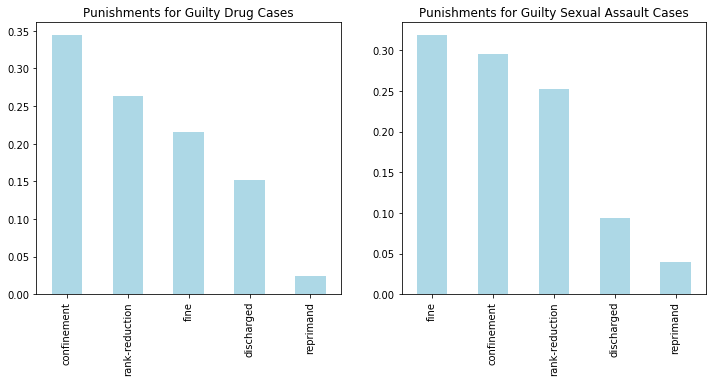

In [1016]:
f, axarr = plt.subplots(1, 2, figsize=(12,5))

(pd.Series(reduce(lambda x,y : x+y, drug_punishments.values, [])).value_counts()
 .pipe(lambda df: (df/df.sum()).plot(
     kind='bar',
     title='Punishments for Guilty Drug Cases',
     color='lightblue',
     ax=axarr[0]
 )))
 
(pd.Series(reduce(lambda x,y : x+y, sexassault_punishments.values, []))
 .value_counts()
 .pipe(lambda df: (df/df.sum()).plot(
     kind='bar',
     title='Punishments for Guilty Sexual Assault Cases',
     color='lightblue',
     ax = axarr[1]
 )));

In [963]:
pay_terms = ['$', ' fined ','forfeit','pay']
fined_punishments = punishments_count[
    punishments_count.apply(
        lambda x: any([term in x for term in pay_terms])
)]

# SAPRO: Similar language, different outcome

In [746]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(min_df=.01, max_df=.9)

rank_idx_mapping = {v:k+1 for k,v in enumerate([
    u'E-1',u'E-2', u'E-3', u'E-4', u'E-5', u'E-6', u'E-7', u'E-8', u'E-9',
    'W-1', u'W-2', u'W-3', u'W-4', u'W-5',
    u'O-1', u'O-2', u'O-3', u'O-4', u'O-5', u'O-6', u'O-8',
])}

outcome_mapping = {v:k for k,v in enumerate(['no court-martial',  u'not guilty', u'guilty'])}

Text(0.5,0,'Similarity')

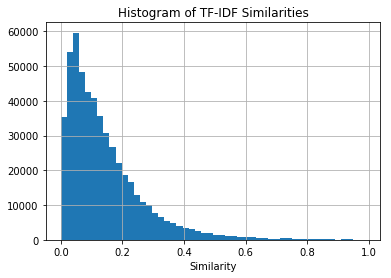

In [157]:
(pd.Series(np.array(mat.dot(mat.T).todense().flatten())[0])
 .pipe(lambda s: s[~np.isclose(s, 1)])
 .hist(bins=50)
)

plt.title('Histogram of TF-IDF Similarities')
plt.xlabel('Similarity')

In [1017]:
recent_army = sapro[(sapro['Subject Service'] == 'ARMY') & (sapro['Year'] == 2016)]
recent_synposis = recent_army['Case Synopsis Note']
case_notes = recent_synposis.apply(lambda x: x.split('Notes:')[1].split('.')[0]).copy()
mat = tfidf.fit_transform(case_notes)

# generate similarities
cutoff=.8
pairs = (pd.DataFrame(np.triu((mat.dot(mat.T) > cutoff).todense(), 1))
 .unstack()
 .pipe(lambda s: s[s])
 .reset_index()[['level_0', 'level_1']]
)

In [1018]:
pairs.shape

(1296, 2)

In [161]:
for idx in range(10): # pairs.shape[0]):
    print case_notes.iloc[pairs.iloc[idx]].values
    print

[u' Victim alleged subject touched her belly and made inappropriate comments about her being pregnant'
 u' Victim alleged Subject made inappropriate sexual comments and slapped her on the buttocks']

[u' Victim alleged subject engaged in sexually harassing and degrading behaviors towards victim'
 u' Victim alleged that Subject wrongfully engaged in sexually explicit conversations']

[u' Victim alleged Subject touched her without her consent'
 u' Victim alleged subject touched her and kissed her without her consent']

[u' Victim alleged abusive sexual contact'
 u' Victim alleged Abusive Sexual Contact']

[u' Victim alleged that Subject raped her'
 u' Victim alleged that Subject raped her and physically assaulted her']

[u' Victim alleged a Sexual Assault' u' Victim alleged sexual assault']

[u' Victim alleged Subject sexually assaulted her'
 u' Victim alleged Subject sexually assaulted her']

[u' Victim originally alleged abusive sexual contact'
 u' Victim alleged Abusive Sexual Contact

In [1019]:
# get record pairs with outcome difference
pair_records = {}
for idx in range(pairs.shape[0]):
    pair_records[idx] = recent_army.iloc[pairs.iloc[idx]]
pair_records = pd.Series(pair_records)
pairs_with_outcome_differences = pair_records[
    pair_records.apply(lambda s1: s1['Outcome'].pipe(lambda s: s.iloc[0] != s.iloc[1]))
]

In [1020]:
pair_records.shape

(1296,)

In [1021]:
pairs_with_outcome_differences.shape

(454,)

In [1022]:
454./1296

0.35030864197530864

In [341]:
t = (pairs_with_outcome_differences.iloc[215]
 .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping[x]))
 .assign(pay_grade_mapping=lambda df: df['Subject Pay Grade'].apply(lambda x: rank_idx_mapping[x]))
 .assign(case_description=lambda df: df['Case Synopsis Note'].apply(lambda x: x.split('Notes:')[1].split('.')[0]))
 .sort_values('outcome_mapping')
 [['case_description','Outcome', 'Subject Pay Grade']]
)
print 'case description:'
print t.case_description.values
t

case description:
[u' Victim alleged Subject had sexual intercourse with her when she was too intoxicated to consent'
 u' Victim alleged that Subject had sexual intercourse with her when she was too intoxicated to consent']


,case_description,Outcome,Subject Pay Grade
5830,Victim alleged Subject had sexual intercourse...,no court-martial,W-1
5784,Victim alleged that Subject had sexual interc...,guilty,E-2


In [338]:
t = (pairs_with_outcome_differences.iloc[70]
 .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping[x]))
 .assign(pay_grade_mapping=lambda df: df['Subject Pay Grade'].apply(lambda x: rank_idx_mapping[x]))
 .assign(case_description=lambda df: df['Case Synopsis Note'].apply(lambda x: x.split('Notes:')[1].split('.')[0]))
 .sort_values('outcome_mapping')
 [['case_description','Outcome', 'Subject Pay Grade']]
)
print 'case description:'
print t.case_description.values
t

case description:
[u' Victim alleged that Subject sexually assaulted her'
 u' Victim alleged Subject sexually and physically assaulted her']


,case_description,Outcome,Subject Pay Grade
5588,Victim alleged that Subject sexually assaulte...,no court-martial,E-7
5465,Victim alleged Subject sexually and physicall...,guilty,E-3


In [330]:
t = (pairs_with_outcome_differences.iloc[170]
 .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping[x]))
 .assign(pay_grade_mapping=lambda df: df['Subject Pay Grade'].apply(lambda x: rank_idx_mapping[x]))
 .assign(case_description=lambda df: df['Case Synopsis Note'].apply(lambda x: x.split('Notes:')[1].split('.')[0]))
 .sort_values('outcome_mapping')
 [['case_description','Outcome', 'Subject Pay Grade']]
)
print 'case description:'
print t.case_description.values
t

case description:
[u' Victim alleged the Subject had sexual intercourse with her when she was too intoxicated to consent'
 u' Victim alleged that Subject had sexual intercourse with her when she was too intoxicated to consent']


,case_description,Outcome,Subject Pay Grade
5771,Victim alleged the Subject had sexual interco...,no court-martial,E-4
5784,Victim alleged that Subject had sexual interc...,guilty,E-2


In [393]:
def get_rank_difference(row):
    temp = (row[['Outcome', 'Subject Pay Grade']]
            .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping.get(x, np.nan)))
            .assign(pay_grade_mapping=lambda df: df['Subject Pay Grade'].apply(lambda x: rank_idx_mapping.get(x, np.nan)))
            .sort_values('outcome_mapping')
            )
    return temp.pay_grade_mapping.pipe(lambda s: s.iloc[0] - s.iloc[1])

def get_hierarchy_diff(row):
    hierarchy = {'E': 0, 'W':2, 'O': 1}
    temp = (row[['Outcome', 'Subject Pay Grade']]
            .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping.get(x, np.nan)))
            .assign(pay_grade_mapping=lambda df: 
                    df['Subject Pay Grade'].apply(lambda x: hierarchy.get(re.search('\w', x).group(), np.nan))
                   )
            .sort_values('outcome_mapping')
           )
    return temp.pay_grade_mapping.pipe(lambda s: s.iloc[0] - s.iloc[1])

def is_higher_rank(row):
    temp = (row[['Outcome', 'Subject Pay Grade']]
            .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping.get(x, np.nan)))
            .assign(pay_grade_mapping=lambda df: df['Subject Pay Grade'].apply(lambda x: rank_idx_mapping.get(x, np.nan)))
            .sort_values('outcome_mapping')
            )
    return pd.Series({
        'higher-rank': temp.pay_grade_mapping.pipe(lambda s: s.iloc[0] > s.iloc[1]),
        'same-rank': temp.pay_grade_mapping.pipe(lambda s: s.iloc[0] == s.iloc[1]),
        'lower-rank': temp.pay_grade_mapping.pipe(lambda s: s.iloc[0] < s.iloc[1])
    })

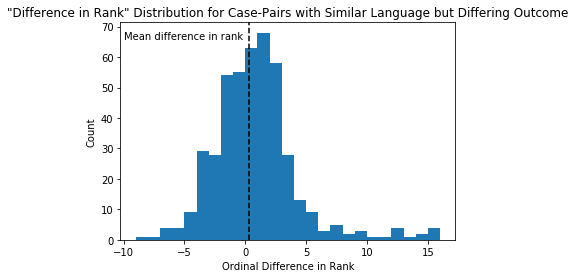

In [353]:
rank_diff = differences.apply( get_rank_difference )

rank_diff.hist(bins=int(rank_diff.max() - rank_diff.min()))
plt.title('"Difference in Rank" Distribution for Case-Pairs with Similar Language but Differing Outcome')
plt.ylabel('Count')
plt.xlabel('Ordinal Difference in Rank')
ylim = plt.ylim()
plt.vlines(rank_diff.mean(), *ylim, linestyles='dashed')
plt.ylim(ylim)
plt.grid()
plt.text(-10, 66, 'Mean difference in rank');

In [394]:
avg_diff = pairs_with_outcome_differences.apply( is_higher_rank)

In [397]:
avg_diff.mean()[['higher-rank','same-rank', 'lower-rank', ]]

higher-rank    0.444934
same-rank      0.138767
lower-rank     0.407489
dtype: float64

In [404]:
avg_diff.assign(division='army', year=2016).groupby(['division', 'year']).mean()

,,higher-rank,lower-rank,same-rank
division,year,,,
army,2016,0.444934,0.407489,0.138767


In [412]:
year

2013

In [417]:
recent_synposis.isnull().sum()

895

In [652]:
def parse_notes(x):
    if 'Notes:' in x:
        return x.split('Notes:')[1].split('.')[0]
    if '.' in x:
        return x.split('.')[0]
    else:
        return x

In [485]:
import itertools

In [740]:
avg_diff_full = pd.DataFrame()
rank_diff_full = pd.DataFrame()

for service, year in itertools.product(
    ['ARMY', u'MARINES', u'AIRFORCE', u'NAVY'],
    [2013, 2014, 2015, 2016]
):
    print (service, year)
    recent_army = sapro[(sapro['Subject Service'] == service) & (sapro['Year'] == year)]
    recent_synposis = recent_army['Case Synopsis Note'].fillna('') + ' ' + recent_army['Narrative of the Crime'].fillna('')
    if (recent_synposis == ' ').sum() != recent_synposis.shape[0]:
        case_notes = recent_synposis.fillna('').apply(parse_notes).copy()
        mat = tfidf.fit_transform(case_notes)

        # generate similarities
        cutoff=.85
        pairs = (pd.DataFrame(np.triu((mat.dot(mat.T) > cutoff).todense(), 1))
         .unstack()
         .pipe(lambda s: s[s])
         .reset_index()[['level_0', 'level_1']]
        )

        # get record pairs with outcome difference
        pair_records = {}
        for idx in range(pairs.shape[0]):
            pair_records[idx] = recent_army.iloc[pairs.iloc[idx]]
        pair_records = pd.Series(pair_records)
        pairs_with_outcome_differences = pair_records[
            pair_records.apply(lambda s1: s1['Outcome'].pipe(lambda s: s.iloc[0] != s.iloc[1]))
        ]

        avg_diff_full = pd.concat([
            avg_diff_full,
            (pairs_with_outcome_differences
                      .apply( is_higher_rank )
                      .assign(service=service)
                      .assign(year=year)
                     )
        ])

        rank_diff_full = pd.concat([
            rank_diff_full,
            (pairs_with_outcome_differences
                       .apply( get_rank_difference )
                       .to_frame('rank differences')
                       .assign( service=service)
                       .assign(year=year)
                      )
        ])

('ARMY', 2013)
('ARMY', 2014)
('ARMY', 2015)
('ARMY', 2016)
(u'MARINES', 2013)
(u'MARINES', 2014)
(u'MARINES', 2015)
(u'MARINES', 2016)
(u'AIRFORCE', 2013)
(u'AIRFORCE', 2014)
(u'AIRFORCE', 2015)
(u'AIRFORCE', 2016)
(u'NAVY', 2013)
(u'NAVY', 2014)
(u'NAVY', 2015)
(u'NAVY', 2016)


In [741]:
rank_diff_full.groupby(['service', 'year']).mean().reset_index().pivot(index='service', columns='year', values='rank differences')

year,2013,2014,2015,2016
service,,,,
AIRFORCE,NaN,-1.5,-1.000000,-0.545455
ARMY,0.093960,NaN,-0.247253,0.648734
MARINES,0.333333,-0.7,0.500000,0.440000
NAVY,0.500277,-0.5,-0.545455,-2.000000


In [742]:
rank_diff_full['rank differences'].mean()

0.4083333333333333

In [526]:
import numpy as np 

In [743]:
avg_diff_full.groupby(['service','year']).aggregate(['mean', 'count'])[['higher-rank', 'same-rank', 'lower-rank', ]]

higher-rank       same-rank       lower-rank      
                     mean count      mean count       mean count
service  year                                                   
AIRFORCE 2013    0.000000     2  0.000000     2   0.000000     2
         2014    0.500000     8  0.000000     8   0.500000     8
         2015    0.388889    18  0.277778    18   0.333333    18
         2016    0.272727    11  0.000000    11   0.727273    11
ARMY     2013    0.345455   165  0.242424   165   0.315152   165
         2015    0.434066   182  0.126374   182   0.439560   182
         2016    0.458861   316  0.129747   316   0.411392   316
MARINES  2013    0.333333    12  0.666667    12   0.000000    12
         2014    0.200000    10  0.300000    10   0.500000    10
         2015    0.333333    12  0.333333    12   0.333333    12
         2016    0.430000   100  0.230000   100   0.340000   100
NAVY     2013    0.432172  1865  0.160322  1865   0.376408  1865
         2014    0.000000     3  0.333333     3   0.333333     3
         2015    0.272727    11  0.181818    11   0.545455    11
         2016    0.500000     2  0.000000     2   0.500000     2

In [744]:
avg_diff_full.mean()

higher-rank       0.426205
lower-rank        0.380199
same-rank         0.165256
year           2013.645565
dtype: float64

# How many cases involve drinking? 

In [564]:
sapro['alcohol_involved'] = (sapro['Alcohol Use']
 .fillna('')
 .apply(lambda x: x.lower())
 .apply(lambda x: 'involved' in x or 'victim' in x or 'subject' in x))

In [566]:
sapro['alcohol_involved'].value_counts()

False    4611
True     3752
Name: alcohol_involved, dtype: int64

In [1029]:
(sapro
 .groupby('alcohol_involved')['Outcome']
 .apply(lambda x: x.value_counts())
 .to_frame('counts')
 .reset_index()
 .rename(columns={'level_1': 'outcome'})
 .pivot(index='outcome', columns='alcohol_involved', values='counts')
 .loc[['no court-martial', 'not guilty', 'guilty']]
 .pipe(lambda df: df/ df.sum())
 .rename(index={'not guilty': 'court-martial, not guilty'})
)

alcohol_involved,False,True
outcome,,
no court-martial,0.791152,0.638060
"court-martial, not guilty",0.066797,0.127132
guilty,0.142052,0.234808


Text(0.5,0,'')

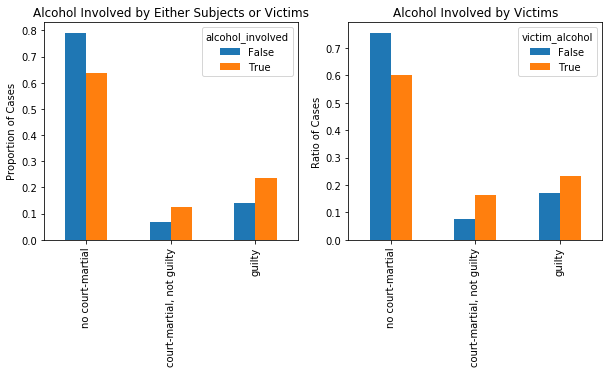

In [1031]:
f, axarr = plt.subplots(1, 2, figsize=(10,4))

(sapro
 .groupby('alcohol_involved')['Outcome']
 .apply(lambda x: x.value_counts())
 .to_frame('counts')
 .reset_index()
 .rename(columns={'level_1': 'outcome'})
 .pivot(index='outcome', columns='alcohol_involved', values='counts')
 .loc[['no court-martial', 'not guilty', 'guilty']]
 .pipe(lambda df: df/ df.sum())
 .rename(index={'not guilty': 'court-martial, not guilty'})
 .plot(kind='bar', ax=axarr[0], title='Alcohol Involved by Either Subjects or Victims')
)
axarr[0].set_ylabel('Proportion of Cases')
axarr[0].set_xlabel('')

(sapro.assign(victim_alcohol=lambda df: df['Alcohol Use'].fillna('').apply(lambda x: 'victim' in x.lower()))
 .groupby('victim_alcohol')['Outcome']
 .apply(lambda x: x.value_counts())
 .to_frame('counts')
 .reset_index()
 .rename(columns={'level_1': 'outcome'})
 .pivot(index='outcome', columns='victim_alcohol', values='counts')
 .loc[['no court-martial', 'not guilty', 'guilty']]
 .pipe(lambda df: df / df.sum())
 .rename(index={'not guilty': 'court-martial, not guilty'})
 .plot(kind='bar', title='Alcohol Involved by Victims', ax=axarr[1])
)
axarr[1].set_ylabel('Ratio of Cases');
axarr[1].set_xlabel('')

# How many male-on-male vs. male-on-female: higher conviction rates, significant differences on the convictions rates and the outcomes?

In [686]:
(sapro
 .assign(victim_gender_parsed=lambda df: df['Victim Gender'].fillna('').apply(lambda x: ['male', 'female']['female' in x.lower()]))
 .assign(subject_gender_parsed=lambda df: df['Subject Gender'].fillna('').apply(lambda x: ['male', 'female']['female' in x.lower()]))
 [['victim_gender_parsed', 'subject_gender_parsed']]
 .assign(c=1)
 .pivot_table(values='c', index='subject_gender_parsed', columns='victim_gender_parsed', aggfunc='sum')
)

victim_gender_parsed,female,male
subject_gender_parsed,,
female,177,102
male,6689,1395


Text(0,0.5,'Count of Punishment Type')

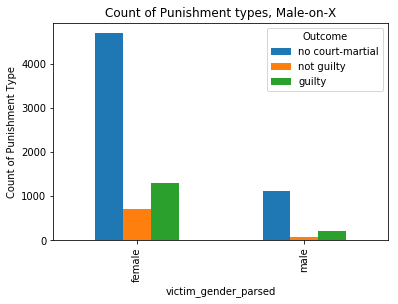

In [728]:
(sapro
 .assign(victim_gender_parsed=lambda df: df['Victim Gender'].fillna('').apply(lambda x: ['male', 'female']['female' in x.lower()]))
 .assign(subject_gender_parsed=lambda df: df['Subject Gender'].fillna('').apply(lambda x: ['male', 'female']['female' in x.lower()]))
 .pipe(lambda df: df[df['subject_gender_parsed'] == 'male'])
 .groupby('victim_gender_parsed')['Outcome'].value_counts()
 .to_frame('count')
 .reset_index()
 .pivot(columns='Outcome', values='count', index='victim_gender_parsed')
 [['no court-martial','not guilty', 'guilty']]
 .plot(kind='bar')
)
plt.title('Count of Punishment types, Male-on-X')
plt.ylabel('Count of Punishment Type')

Text(0,0.5,'Likelihood of Punishment Type')

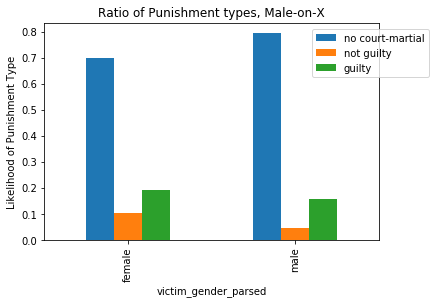

In [727]:
(sapro
 .assign(victim_gender_parsed=lambda df: df['Victim Gender'].fillna('').apply(lambda x: ['male', 'female']['female' in x.lower()]))
 .assign(subject_gender_parsed=lambda df: df['Subject Gender'].fillna('').apply(lambda x: ['male', 'female']['female' in x.lower()]))
 .pipe(lambda df: df[df['subject_gender_parsed'] == 'male'])
 .groupby('victim_gender_parsed')['Outcome'].value_counts()
 .to_frame('count')
 .reset_index()
 .pivot(columns='Outcome', values='count', index='victim_gender_parsed')
 [['no court-martial','not guilty', 'guilty']]
 .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
 .plot(kind='bar')
)
plt.legend(loc=(.8, .75))
plt.title('Ratio of Punishment types, Male-on-X')
plt.ylabel('Likelihood of Punishment Type')

# Rank Effect Patterns between Victim and Subject

In [786]:
rank_idx_mapping = {v:k+1 for k,v in enumerate([
    u'E-1',u'E-2', u'E-3', u'E-4', u'E-5', u'E-6', u'E-7', u'E-8', u'E-9',
    u'O-1', u'O-2', u'O-3', u'O-4', u'O-5', u'O-6', u'O-8',
     'W-1', u'W-2', u'W-3', u'W-4', u'W-5',
])}

In [788]:
sapro_rank_differences = (sapro
 .assign(victim_pay_ord=lambda df: df['Victim Pay Grade'].apply(lambda x: rank_idx_mapping.get(x, 0)))
 .assign(subject_pay_ord=lambda df: df['Subject Pay Grade'].apply(lambda x: rank_idx_mapping.get(x, 0)))
 .assign(rank_difference=lambda df: df['subject_pay_ord'] - df['victim_pay_ord'] )
)

Text(4,1750,'0.972139')

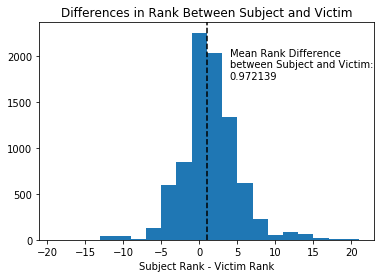

In [789]:
sapro_rank_differences['rank_difference'].hist(bins=20)
plt.grid()
plt.title('Differences in Rank Between Subject and Victim')
ylim = plt.ylim()
plt.vlines(sapro_rank_differences['rank_difference'].mean(), *ylim, linestyles='dashed')
plt.ylim(ylim)
plt.xlabel('Subject Rank - Victim Rank')
plt.text(4, 2000, 'Mean Rank Difference')
plt.text(4, 1875, 'between Subject and Victim:')
plt.text(4, 1750, '%f' % sapro_rank_differences['rank_difference'].mean())

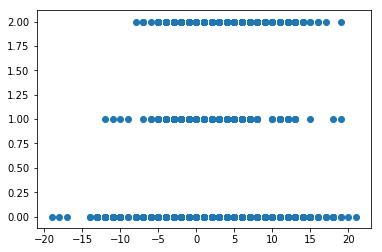

In [790]:
(sapro_rank_differences
 .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping[x]))
 [['rank_difference','outcome_mapping']]
).pipe(lambda df: plt.scatter(df['rank_difference'], df['outcome_mapping']))

In [794]:
(sapro_rank_differences
 .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping[x]))
 [['rank_difference', 'outcome_mapping']]
).corr()

,rank_difference,outcome_mapping
rank_difference,1.000000,0.159482
outcome_mapping,0.159482,1.000000


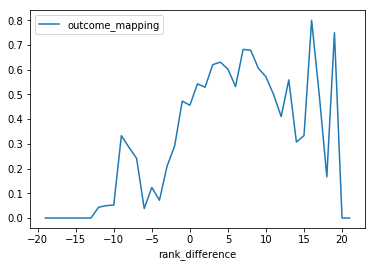

In [795]:
(sapro_rank_differences
 .assign(outcome_mapping=lambda df: df['Outcome'].apply(lambda x: outcome_mapping[x]))
 [['rank_difference','outcome_mapping']]
).groupby('rank_difference').mean().plot()

In [808]:
hierarchy = {'E': 0, 'W':1, 'O': 2}

(sapro
 .assign(subject_pay_grade_mapping=lambda df: 
    df['Subject Pay Grade'].fillna('Z').apply(lambda x: hierarchy.get(re.search('\w', x).group(), np.nan))
   )
  .assign(victim_pay_grade_mapping=lambda df: 
    df['Victim Pay Grade'].fillna('Z').apply(lambda x: hierarchy.get(re.search('\w', x).group(), np.nan))
   )
[['subject_pay_grade_mapping', 'victim_pay_grade_mapping']]
 .assign(c=1)
 .pivot_table(columns='victim_pay_grade_mapping', index='subject_pay_grade_mapping', values='c', aggfunc='sum')
 .rename(columns={0:'E', 1:'W', 2:'O'})
 .rename(index={0:'E', 1:'W', 2:'O'})
 .fillna(0)
)

victim_pay_grade_mapping,E,W,O
subject_pay_grade_mapping,,,
E,4310.0,0.0,38.0
W,24.0,0.0,6.0
O,130.0,1.0,128.0


In [ ]:
sapro.reset_index()

In [884]:
t = (sapro
 .assign(subject_pay_grade_mapping=lambda df: 
    df['Subject Pay Grade'].fillna('Z').apply(lambda x: hierarchy.get(re.search('\w', x).group(), np.nan))
   )
  .assign(victim_pay_grade_mapping=lambda df: 
    df['Victim Pay Grade'].fillna('Z').apply(lambda x: hierarchy.get(re.search('\w', x).group(), np.nan))
   )
 .assign(c=1)
 .groupby(['subject_pay_grade_mapping','victim_pay_grade_mapping', 'Outcome'])['c']
 .sum()
 .to_frame('count')
 .reset_index(2)
#  .pivot(columns='Outcome', values='count')
)

In [885]:
t2 = (t.reset_index()
      .assign(index=lambda df: df.apply(lambda x: (
          ('Subject Grade', {0:'E', 1:'W', 2:'O'}[x['subject_pay_grade_mapping']]), 
          ('Victim Grade', {0:'E', 1:'W', 2:'O'}[x['victim_pay_grade_mapping']])
      ), axis=1))
      .pivot_table(index='index', columns='Outcome',values='count').fillna(0)
     )

Text(0,0.5,'Counts')

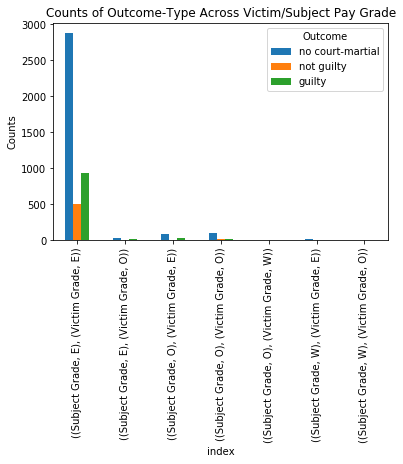

In [903]:
t2[['no court-martial', 'not guilty', 'guilty']].plot.bar()
plt.title('Counts of Outcome-Type Across Victim/Subject Pay Grade')
plt.ylabel('Counts')

Text(0,0.5,'Ratio')

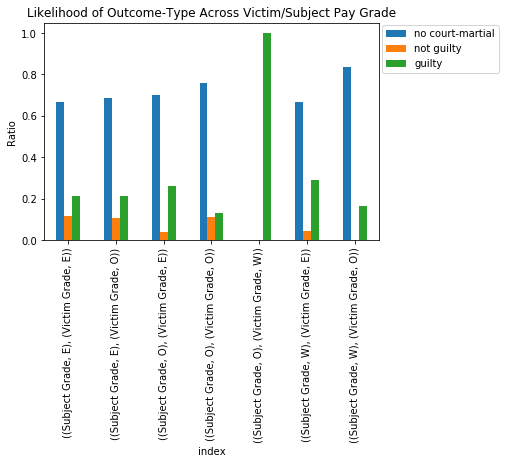

In [902]:
((t2.divide(t2.sum(axis=1), axis=0))
 [['no court-martial', 'not guilty', 'guilty']]
 .plot.bar()
)
plt.legend(loc=(1.01,.77))
plt.title('Likelihood of Outcome-Type Across Victim/Subject Pay Grade')
plt.ylabel('Ratio')